* [The Pet-Finder Competition on Kaggle](https://www.kaggle.com/c/petfinder-adoption-prediction)
* [My notebook location](https://www.kaggle.com/reginashay/petfinder-xgb)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re  # regular expressions

# Main information

In this competition we predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted.

**File descriptions**
* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat. 
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

**Data Fields**
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

**AdoptionSpeed**

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
* 0 - Pet was adopted on the same day as it was listed. 
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

# Import fast.ai library
https://course.fast.ai

Code in the following cell is taken from: https://github.com/fastai/fastai/blob/master/old/fastai/structured.py

In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype


def train_cats(df):
    """
    Change any columns of strings in a pandas' dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()


def fix_missing(df, col, name, na_dict):
    """
    Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def numericalize(df, col, name, max_n_cat):
    """
    Changes the column col from a categorical type to it's integer codes.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1


def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """
    Takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

# Data

### TRAIN set

In [3]:
train = pd.read_csv('../input/train/train.csv')
#to_drop = ['Name', 'Description', 'RescuerID']   # optional
#to_drop = ['Description', 'RescuerID']           # optional
to_drop = ['PetID', 'Description', 'RescuerID']  # optional: categorical data with too many unique values
to_drop.append('Name')                           # optional (we try to make the best out of XGB)
train.drop(to_drop, axis=1, inplace=True)        # optional
train.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2


In [4]:
train.shape

(14993, 20)

Make changes to the Name column:
* clean and fill nan.

In [5]:
#train.isna().sum()
#train.Description = train.Description.fillna('None')

# replace nan values with a string:
#train.Name = train.Name.fillna('NoNameSpecified')
##train.Name = train.Name.fillna('Baby')

# clean: remove all characters except for alphanumeric:
# (NB: removed characters are replaced with a zero length string)
##train.Name = train.Name.map(lambda name: re.sub('[^A-Za-z0-9]+', '', name))

# replacing zero length strings that appeared after cleaning (above):
##train.loc[train.Name == '', 'Name'] = 'NoNameLostIt'

#train.isna().sum()

In [6]:
# count unique Names:
##train.Name.nunique()

Let's see what names we have here:

In [7]:
##train.Name.value_counts()

#train[train.Name.apply(lambda x: len(str(x))) < 2].Name.value_counts()
#train[train.Name.str.startswith('No')].Name.value_counts()

Some more info: current shape, column types and feature correlation

In [8]:
train.shape

(14993, 20)

In [9]:
train.dtypes

Type               int64
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
VideoAmt           int64
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

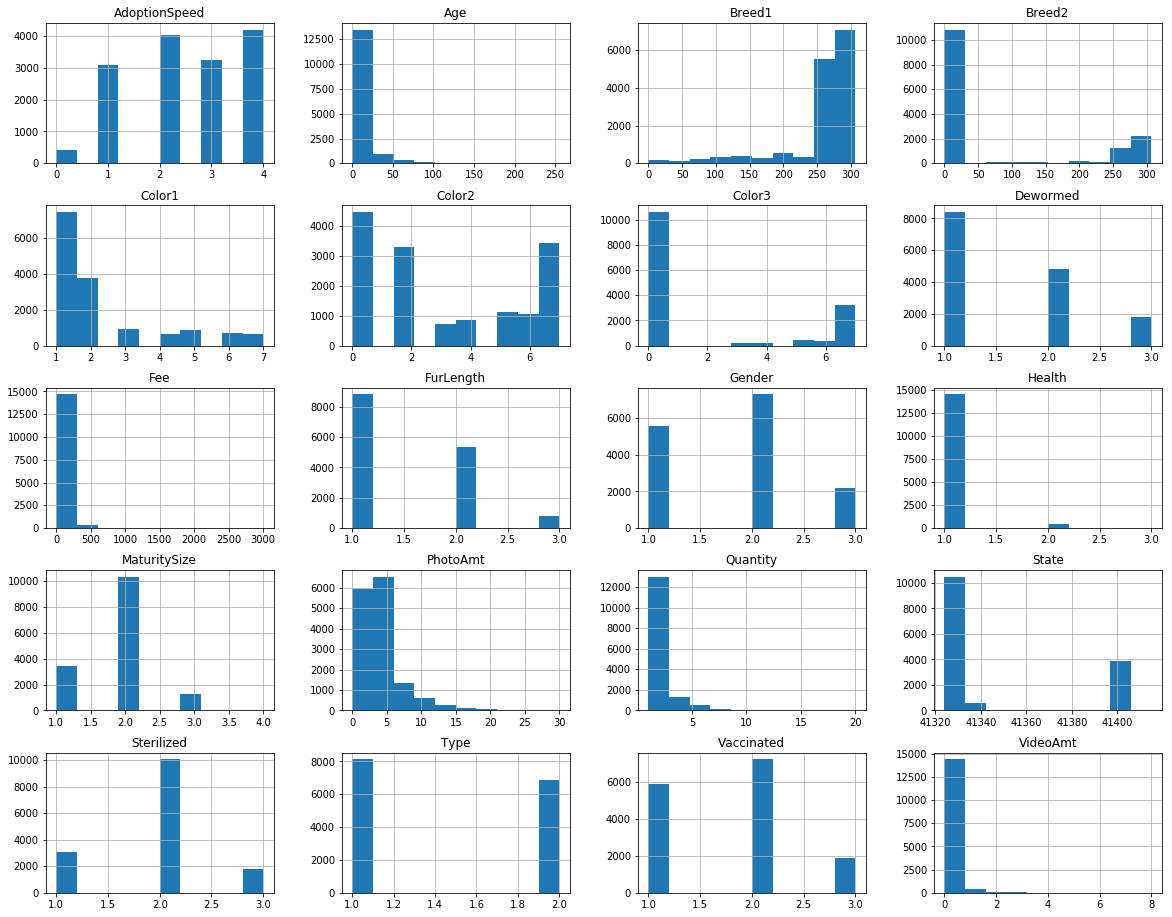

In [10]:
#plt.figure(figsize=(20,16))
train.hist(figsize=(20,16));  # info about features

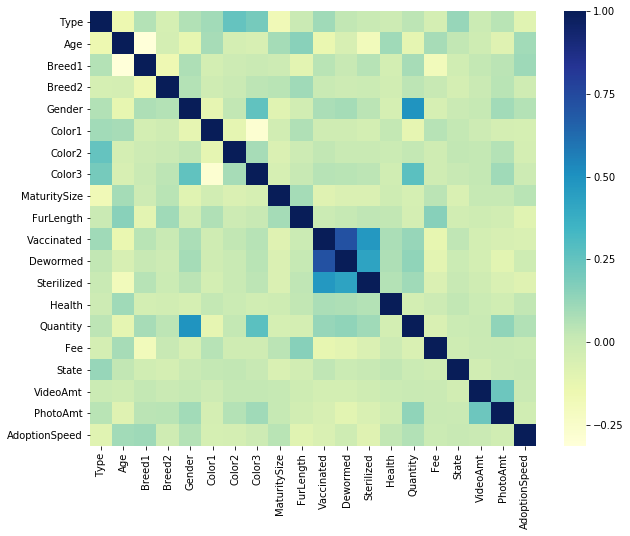

In [11]:
# feature correlation
#plt.figure(figsize=(20,16))
plt.figure(figsize=(10,8))
corr = train.corr()
sns.heatmap(corr, cmap='YlGnBu',  #annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

We see above that mostly, features are slightly correlated with each other, but there are some exceptions.

Let's work with that below:

In [12]:
# drop features that are badly correlated with others
#feat_drop = ['Breed2', 'MaturitySize', 'VideoAmt', 'State']

# drop features that are too well correlated with each other (gives better results in classification)
feat_drop = ['Dewormed', 'Vaccinated', 'Sterilized']

train.drop(feat_drop, axis=1, inplace=True)
train.shape

(14993, 17)

Use fast.ai library to transform categorical data (Name) for classification:

In [13]:
##train_cats(train)
##train.Name.cat.set_categories(list(train.Name.cat.categories), ordered=True, inplace=True)
##train.Name = train.Name.cat.codes

#train.PetID.cat.set_categories(list(train.PetID.cat.categories), ordered=True, inplace=True)
#train.PetID = train.PetID.cat.codes

Result:
* names are represented as numbers.

In [14]:
##train.head()

In [15]:
##train.dtypes  # now the dataset is numeric entirely

### TEST set

In [16]:
test = pd.read_csv('../input/test/test.csv')
test.drop(to_drop, axis=1, inplace=True)  # optional
test.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
0,2,8,266,266,1,2,6,7,1,1,1,1,2,1,2,0,41326,0,2.0
1,2,36,285,264,2,1,4,7,2,3,1,1,1,2,1,0,41326,0,1.0
2,2,2,265,0,1,6,7,0,2,2,1,1,2,1,1,200,41326,0,4.0
3,1,12,307,0,2,2,5,0,2,2,1,1,1,1,2,0,41326,0,5.0
4,2,12,265,0,1,2,3,7,2,2,1,1,1,1,1,0,41326,0,5.0


Same as the train set:
* clean and fill nan for Name.

In [17]:
#test.isna().sum()
#test.Description = test.Description.fillna('None')

# replace nan values with a string:
#test.Name = test.Name.fillna('NoNameSpecified')
##test.Name = test.Name.fillna('Baby')

# clean: remove all characters except for alphanumeric:
# (NB: removed characters are replaced with a zero length string)
##test.Name = test.Name.map(lambda name: re.sub('[^A-Za-z0-9]+', '', name))

# replacing zero length strings that appeared after cleaning (above):
##test.loc[test.Name == '', 'Name'] = 'NoNameLostIt'

#test.isna().sum()

Names in the test set:

In [18]:
##test.Name.value_counts()

In [19]:
#test.isna().sum()
test.shape

(3972, 19)

Drop features the same way as in the train set

In [20]:
test.drop(feat_drop, axis=1, inplace=True)
test.shape

(3972, 16)

Use fast.ai library to transform categorical data (Name) for classification:

In [21]:
##train_cats(test)
##test.Name.cat.set_categories(list(test.Name.cat.categories), ordered=True, inplace=True)
##test.Name = test.Name.cat.codes

#test.PetID.cat.set_categories(list(test.PetID.cat.categories), ordered=True, inplace=True)
#test.PetID = test.PetID.cat.codes

In [22]:
test.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
0,2,8,266,266,1,2,6,7,1,1,1,2,0,41326,0,2.0
1,2,36,285,264,2,1,4,7,2,3,2,1,0,41326,0,1.0
2,2,2,265,0,1,6,7,0,2,2,1,1,200,41326,0,4.0
3,1,12,307,0,2,2,5,0,2,2,1,2,0,41326,0,5.0
4,2,12,265,0,1,2,3,7,2,2,1,1,0,41326,0,5.0


### BREEDS, COLORS AND STATES sets

In [23]:
#breeds = pd.read_csv('../input/breed_labels.csv')
#breeds.head()

In [24]:
#breeds.shape

In [25]:
#colors = pd.read_csv('../input/color_labels.csv')
#colors

In [26]:
#states = pd.read_csv('../input/state_labels.csv')
#states

# Models

In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold  #, train_test_split
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

What are we predicting?

In [28]:
train.AdoptionSpeed.unique()  #hist(figsize=(6,4));

array([2, 0, 3, 1, 4])

How are we predicting?

Submissions are scored based on the **quadratic weighted kappa**, which measures the agreement between two ratings. This metric typically varies from 0 (random agreement between raters) to 1 (complete agreement between raters). In the event that there is less agreement between the raters than expected by chance, the metric may go below 0. The quadratic weighted kappa is calculated between the scores which are expected/known and the predicted scores.

Prepare the scorer: 

In [29]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics

def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [30]:
#kappa_scorer = make_scorer(cohen_kappa_score(weights='quadratic'), greater_is_better=True)  # wrong
kappa_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

Split the data using fast.ai's proc_df function:

In [31]:
X, y, nan = proc_df(train, 'AdoptionSpeed')

#X = train.drop(['AdoptionSpeed'], axis=1)
#y = train.AdoptionSpeed
#X_train, X_test, y_train, y_test = train_test_split(X, y)

## DecisionTreeClassifier

Best parameters search

In [32]:
#tree = DecisionTreeClassifier()
#tree_params = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : list(range(2, 11))
#}
#tree_grid = GridSearchCV(tree, tree_params, n_jobs=-1, cv=5, verbose=True, scoring=kappa_scorer)
#tree_grid.fit(X, y);

In [33]:
#tree_grid.best_params_, tree_grid.best_score_

## RandomForestClassifier

Parameters search

In [34]:
#max_depth_values = range(2, 16)
#max_features_values = range(2, 16)
#n_estimators = [60, 70]  #[40, 50, 60]
#forest_params = {'max_depth': max_depth_values,
#                 'max_features': max_features_values,
#                 'n_estimators': n_estimators}

In [35]:
#skf = StratifiedKFold(n_splits=5, shuffle=True)

In [36]:
#%%time
#forest = RandomForestClassifier()
#rf_grid = GridSearchCV(forest, forest_params, n_jobs=-1, scoring=kappa_scorer, cv=skf)
#rf_grid.fit(X, y);

In [37]:
#rf_grid.best_params_, rf_grid.best_score_

## XGBClassifier

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [39]:
max_depth_values = range(3, 9)
min_child_weight = range(1, 3)
n_estimators = [80]
xgb_params = {
    'max_depth' : max_depth_values,
    'min_child_weight' : min_child_weight,
    'n_estimators' : n_estimators,
}

In [40]:
%%time
xgb = XGBClassifier()  #subsample=0.7)
xgb_grid = GridSearchCV(xgb, xgb_params, n_jobs=-1, scoring=kappa_scorer, cv=skf)  #5)
xgb_grid.fit(X, y);

CPU times: user 7.01 s, sys: 164 ms, total: 7.17 s
Wall time: 2min 23s


In [41]:
xgb_grid.best_params_, xgb_grid.best_score_

({'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 80},
 0.34159905117579403)

In [42]:
xgb_grid.best_estimator_.predict(test)

array([4, 1, 1, ..., 4, 4, 4])

# Submission

In [43]:
sub = pd.read_csv('../input/test/sample_submission.csv')

#pred = tree_grid.predict(test)
#pred = rf_grid.predict(test)
pred = xgb_grid.predict(test)

sub['AdoptionSpeed'] = pd.Series(pred)
sub.to_csv('submission.csv', index=False)